# Sphere center detection for extrinsic calibration

Suppose we capture a sphere (i.e., a ball on a *calibration wand*) by multiple cameras, and detect the sphere center in each image as corresponding points for extrinsic calibration.  Since perspective projection of a sphere is an ellipse on the image plane, we need to find the projection of the sphere center from an ellipse.

We here assume that the ball detection has been done somehow, by color-based segmentation (`tools/detect_by_color_gui.py`) for example.  That is, our input is a binary image such that only the ball area (i.e., ellipse) is in white as follows.

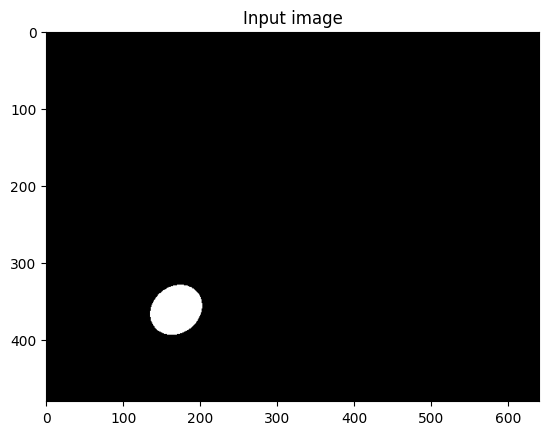

Sphere center in 3D (GT): [-50  40 100]
Sphere center in 2D (GT): [170. 360.   1.]


In [15]:
%matplotlib inline
import sys, os, cv2
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pycalib

# dummy data
W = 640
H = 480
fx = 300
fy = fx
u0 = W // 2
v0 = H // 2
K = np.array( [[ fx, 0, u0 ], [0, fy, v0], [0, 0, 1]])
RADIUS = 10

# GT sphere center in 3D
C_gt = np.array([-50, 40, 100])

# GT sphere center in 2D
c_gt = K @ C_gt.reshape((3,1))
c_gt = (c_gt / c_gt[2]).flatten()

# Input image
img = pycalib.render_sphere(C_gt, RADIUS, K, W, H)

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Input image')
plt.show()

print(f'Sphere center in 3D (GT): {C_gt}')
print(f'Sphere center in 2D (GT): {c_gt}')

First, we need to find an ellipse from this image.

Ellipse center in 2D: ((168.4770965576172, 361.1709289550781), (60.10383224487305, 71.46420288085938), 51.37413024902344)


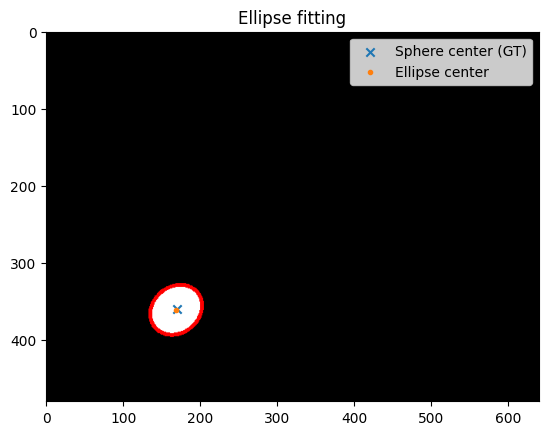

In [16]:
ellipses = pycalib.fit_ellipse(img, force_convex_hull=True)

buf = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.figure()
plt.scatter(c_gt[0], c_gt[1], marker='x', label='Sphere center (GT)')

for ellipse, contour in ellipses:
    buf = cv2.ellipse(buf, ellipse, (255,0,0), 4)
    plt.scatter(ellipse[0][0], ellipse[0][1], marker='.', label='Ellipse center')
    print(f'Ellipse center in 2D: {ellipse}')

    # in this example, we check the first ellipse only
    break

plt.imshow(buf)
plt.legend()
plt.title('Ellipse fitting')
plt.show()



We can compute the sphere center by `pycalib.calc_sphere_center_from_ellipse()`.

In [17]:
c = pycalib.calc_sphere_center_from_ellipse(ellipse, K)

print(f'Sphere center in 3D (GT): {C_gt}')
print(f'Sphere center in 2D (GT): {c_gt}')
print(f'Ellipse center in 2D    : {np.array(ellipse[0])} (err={np.linalg.norm(c_gt[:2] - ellipse[0]):.02f}px)')
print(f'Sphere center in 2D     : {c} (err={np.linalg.norm(c_gt[:2] - c[:2]):.02f}px)')

assert np.allclose(c[:2], c_gt[:2], atol=1.0), "center detection should be sub-pix accuracy"

Sphere center in 3D (GT): [-50  40 100]
Sphere center in 2D (GT): [170. 360.   1.]
Ellipse center in 2D    : [168.47709656 361.17092896] (err=1.92px)
Sphere center in 2D     : [169.98186115 359.96758794] (err=0.04px)


## Notes

* `pycalib` has another function named `fit_sphere_center_3d_to_ellipse()` that estimates the 3D center given the original radius of the sphere.  This is implemented by a numerical optimization and runs much slower (50x) than `calc_sphere_center_from_ellipse()`.
* The accuracy of `calc_sphere_center_from_ellipse()` totally depends on that of the ellipse fitting.
  * The image should be undistorted beforehand.
  * Orientation: Internally the function assumes that the major axis is directed to the image center $(u_0, v_0)$, while `cv2.fitEllipse()` does not enforce such constraint.  It will be better if the fitting can enforce the ellipse to be orieted to the image center.
  * Occlusion, partial ellipse image: Fitting an ellipse to a partial ellipse image can be a difficult task.  Small notches due to the wand for exampe can be filled inside `pycalib.fit_ellipse()` by specifying `force_convex_hull=True`.
* The above point also suggests that it is not a good idea to optimize the intrinsic parameters too much in the bundle adjustment using corresponding points given by sphere centers.  Strictly speaking, changes in the intrinsic parameter results in changes in the image undistortion, contour detection, ellipse fitting, and the sphere center estimation from the ellipse.